## Protein Embeddings Manipulation

In [31]:
from pathlib import Path

data_path = Path("../data/Protera") 

!ls $data_path

clustering     prism			       stability_test_diversity.csv
cluster.out    search.out		       stability_train.csv
data.csv       sequences.fasta		       stability_train_diversity.csv
mmseq	       stability.csv		       stability_train.h5
mmseq_q        stability_embeddings_test.pkl   stability_with_dups.csv
mmseq_t        stability_embeddings_train.pkl  tmp
prefilter.out  stability_test.csv


In [32]:
from pathlib import Path
import matplotlib.pyplot as plt

from protera_stability.data import ProteinStabilityDataset

### Get Dataset

In [33]:
train_set = ProteinStabilityDataset(proteins_path=data_path / "stability_train.h5")
len(train_set)

32001

In [34]:
train_set.X.mean(), train_set.X.var(), train_set.X.shape

(-1.5524662e-10, 0.9999989, (32001, 1280))

In [35]:
train_set.y.mean(), train_set.y.var(), train_set.y.shape

(7.629156e-09, 0.99999994, (32001,))

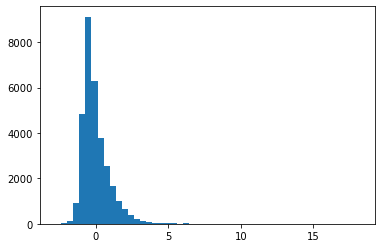

In [36]:
plt.hist(train_set.y, bins=50)
plt.show()

## Dimensionality Reduction

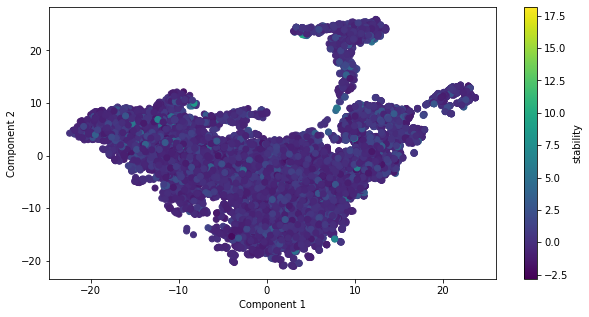

In [37]:
from protera_stability.utils.decomposition import dim_reduction

X = dim_reduction(train_set.X, train_set.y, n_components=32, plot_viz=True, prefix="stability")

In [38]:
from protera_stability.utils import perform_search

from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, train_set.y, random_state=123)

# scoring = "r2"
# score = r2_score
# models = {
#     "SVR": {
#         "model": SVR(),
#         "params": {
#             "C": [0.1, 1.0, 10.0],
#             "kernel": ["linear", "poly", "rbf", "sigmoid"],
#             "degree": [3],
#             "gamma": ["scale"],
#         },
#     },
#     "MLP": {
#         "model": MLPRegressor(),
#         "params": {
#             "hidden_layer_sizes": [(100,), (100, 100), (1024, 1024)],
#             "activation": ["tanh", "relu"],
#             "solver": ["sgd", "adam"],
#         },
#     },
# }

# for name, model in models.items():
#     perform_search(
#         X_train,
#         y_train,
#         model["model"],
#         model["params"],
#         name,
#         X_test=X_val,
#         y_test=y_val,
#         save_dir="../models",
#         n_jobs=8,
#     )

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args

import numpy as np

reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, X_train.shape[1], name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
# res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# "Best score=%.4f" % res_gp.fun

In [41]:
!ls $data_path

clustering     prism			       stability_test_diversity.csv
cluster.out    search.out		       stability_train.csv
data.csv       sequences.fasta		       stability_train_diversity.csv
mmseq	       stability.csv		       stability_train.h5
mmseq_q        stability_embeddings_test.pkl   stability_with_dups.csv
mmseq_t        stability_embeddings_train.pkl  tmp
prefilter.out  stability_test.csv


In [42]:
test_set = ProteinStabilityDataset(proteins_path=data_path / "stability_test.h5")
X_test = dim_reduction(test_set.X, test_set.y, n_components=32, plot_viz=False)

In [43]:
model = SVR(**{'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'})

# model.fit(X_train, y_train)
# model.score(X_test, test_set.y)

In [44]:
model = MLPRegressor(**{'activation': 'relu', 'hidden_layer_sizes': (1024, 1024), 'solver': 'adam'})

# model.fit(X_train, y_train)
# model.score(X_test, test_set.y)

## Can a FeedForward Net do better?


In [46]:
from torch import nn
import torch

class ProteinMLP(nn.Module):
    def __init__(self, n_in = 1280, n_units = 2048, emb_dim = 1024, act = None, drop_p = 0.7, last_drop = True):
        super(ProteinMLP, self).__init__()
        self.fc1 = nn.Linear(n_in, n_units)
        self.fc2 = nn.Linear(n_units, n_units)
        self.new_emb = nn.Linear(n_units, emb_dim)
        self.fc3 = nn.Linear(emb_dim, 1)
        
        self.drop = nn.Dropout(p=drop_p)
        self.bn1 = nn.BatchNorm1d(n_units)
        self.bn2 = nn.BatchNorm1d(n_units)


        self.last_drop = last_drop
        self.act = act
        if act is None:
            self.act = nn.ReLU6()
            
    def forward(self, x):
        out = self.drop(self.act(self.fc1(x)))
        out = self.drop(self.act(self.fc2(out)))
        out = self.act(self.new_emb(out))
        
        if self.last_drop: 
            out = self.drop(out)
        return self.fc3(out)

In [67]:
from skorch.callbacks import Checkpoint, LRScheduler, EarlyStopping
from skorch import NeuralNetRegressor

cb = Checkpoint(dirname='models')
sched = LRScheduler(step_every="epoch")
stopper = EarlyStopping(patience=15)

net = NeuralNetRegressor(
    ProteinMLP,
    criterion=nn.MSELoss,
    # optimizer=torch.optim.Adam,
    # optimizer__momentum=0.05,
    optimizer__weight_decay=1e-2,
    max_epochs=int(1e4),
    lr=3e-3,
    iterator_train__shuffle=True,
    device='cuda:1',
    callbacks=[cb, sched, stopper],
    module__n_units=1024,
    module__n_in=32
)

# net.fit(train_set.X, train_set.y.reshape(-1,1))

# net.score(test_set.X, test_set.y)

In [55]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

net.verbose=0

params = {
    'lr': Real(1e-6, 1, "log-uniform"),
    "optimizer__momentum" : Real(0.01, 0.5, "log-uniform"),
    "optimizer__weight_decay" : Real(1e-5, 1e-1, "log-uniform"),
    "module__n_units": Categorical([512, 1024, 2048]),
    # "module__drop_p": Real(0.5, 0.8, "uniform"),
    "module__act": Categorical([nn.RReLU(), nn.GELU(), nn.ReLU6(), nn.Mish()]),
}
gs = BayesSearchCV(net, params, refit=False, cv=3, scoring='r2', verbose=1, n_jobs=3, n_iter=3, return_train_score=True)

gs.fit(train_set.X, train_set.y.reshape(-1,1))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   36.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   51.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   41.2s finished


BayesSearchCV(cv=3,
              estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=ProteinMLP(
    (fc1): Linear(in_features=1280, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=1024, bias=True)
    (new_emb): Linear(in_features=1024, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=1, bias=True)
    (drop): Drop...
                             'module__act': Categorical(categories=(RReLU(lower=0.125, upper=0.3333333333333333), GELU(), ReLU6(), Mish()), prior=None),
                             'module__n_units': Categorical(categories=(512, 1024, 2048), prior=None),
                             'optimizer__momentum': Real(low=0.01, high=0.5, prior='log-uniform', transform='identity'),
                             'optimizer__weight_decay': Real(low=1e-05, high=0.1, prior='log-uniform', transform='identity')},
              verbose=1)

In [25]:
gs.best_params_, gs.best_score_

(OrderedDict([('lr', 5.784869271331466e-05),
              ('module__act', ReLU6()),
              ('module__n_units', 1024),
              ('optimizer__momentum', 0.05746036965136543),
              ('optimizer__weight_decay', 0.08059427360881438)]),
 0.1495246935776962)

In [81]:
from scipy.stats import loguniform
from sklearn.preprocessing import StandardScaler
net.verbose=0
params = {
    'lr': loguniform(1e-6, 1).rvs(4),
    "optimizer__momentum" :  loguniform(0.01, 0.5).rvs(3),
    "optimizer__weight_decay" : loguniform(1e-5, 1e-1).rvs(3),
    "module__n_units": [512, 1024, 2048],
    # "module__drop_p": Real(0.5, 0.8, "uniform"),
    "module__act": [nn.RReLU(), nn.GELU(), nn.ReLU6()],
}

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train.reshape(-1,1))


gs = perform_search(X_train, y_train, net, params, name="gs-mlp", n_jobs=4)

Fitting model gs-mlp...
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 46.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 102.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 151.5min


KeyboardInterrupt: 